# 针对用户在豆瓣电影留下的评论数据，对其进行分词、词性标注和去除停用词等文本预处理。基于预处理后的数据进行情感分析，同时进行电影的推荐，并使用LDA主题模型提取评论关键信息，以了解用户的需求、意见、购买原因及电影的优缺点等，最终提出改善电影的建议

# 一.数据预处理

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import jieba.posseg as psg#jieba.posseg不仅能够划分词，还能够显示出词性
import re
import warnings#忽略警告模块
warnings.filterwarnings("ignore")
%matplotlib inline
path = 'C:/Users/Administrator/Desktop/豆瓣电影'#设置路径

In [4]:
data=pd.read_csv(r'C:\Users\Administrator\Desktop\豆瓣电影\DMSC.csv')

因数据集过大因此在数据集中采用随机抽样的方式，抽取30000个数据集

In [126]:
data=shuffle(data)[:30000]#随机抽取数据集中30000个样本

In [127]:
data.index=range(data.shape[0])#将乱序的索引重新排列

选取电影名称，评论，以及评分

In [128]:
movie=data.loc[:,['Movie_Name_CN','Comment','Star']]

In [129]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Movie_Name_CN  20000 non-null  object
 1   Comment        20000 non-null  object
 2   Star           20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [130]:
def clean_str(line):
    line.strip('\n')
    line = re.sub(r"[^\u4e00-\u9fff]", "", line)
    line = re.sub(
        "[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "", line)
    return line.strip()
#定义一个函数去除这些特殊符号和英文字段

In [131]:
movie['Comment']=movie['Comment'].apply(clean_str)

In [132]:
movie.head()

,Movie_Name_CN,Comment,Star
0,大圣归来,情怀,4
1,夏洛特烦恼,看的时候笑得不要不要的但是我不喜欢这片子传递的价值观,3
2,左耳,水军是没有看电影电影里面哪里有怀孕堕胎虽然小说里面是有的我不说他拍的特别好至少有哭点有泪点我...,5
3,美人鱼,虽然剧情没新意但是段子都好好笑特别是警局那段全场爆笑环保也起到了效果看完再也不想吃整条鱼最大...,4
4,后会无期,我们就像公路,3


利用jieba.posseg进行分词的切分，并返回其词性

In [133]:
worker = lambda s: [(x.word, x.flag) for x in psg.cut(s)] # 自定义简单分词函数
seg_word = movie['Comment'].apply(worker)

In [134]:
seg_word

0                                                [(情怀, n)]
1        [(看, v), (的, uj), (时候, n), (笑, v), (得, ud), (不...
2        [(水军, n), (是, v), (没有, v), (看, v), (电影, n), (电...
3        [(虽然, c), (剧情, n), (没, v), (新意, n), (但是, c), (...
4                       [(我们, r), (就, d), (像, v), (公路, n)]
                               ...                        
19995    [(看, v), (我, r), (女神, n), (的, uj), (结局, n), (还...
19996    [(星, n), (剧作, n), (星, n), (制作, vn), (突然, ad), ...
19997    [(如果, c), (看, v), (应该, v), (感受, v), (会, v), (更...
19998    [(惊叹, v), (于, p), (男主角, n), (超乎寻常, i), (的, uj)...
19999    [(去, v), (电影院, n), (看, v), (了, ul), (三遍, m), (...
Name: Comment, Length: 20000, dtype: object

In [135]:
# 将词语转为数据框形式，一列是词，一列是词语所在的句子ID，最后一列是词语在该句子的位置
n_word = seg_word.apply(lambda x: len(x))#每一条评论划分好词后的个数
n_content = [[x+1]*y for x,y in zip(list(seg_word.index), list(n_word))]
# 将嵌套的列表展开，作为词所在评论的id

In [136]:
index_content = sum(n_content,[])#sum(x,[])是将[]里面的数字全部取出来并依次排列

In [137]:
seg_word = sum(seg_word, [])
# 词
word = [x[0] for x in seg_word]
# 词性
nature = [x[1] for x in seg_word]

In [138]:
content_type = [[x]*y for x,y in zip(list(movie['Star']), list(n_word))]#[x]*y代表将[x]重复y次
# 评论类型
content_type = sum(content_type, [])

In [139]:
result = pd.DataFrame({"index_content":index_content, 
                       "word":word,
                       "nature":nature,
                       "content_type":content_type})

In [140]:
result.head()

,index_content,word,nature,content_type
0,1,情怀,n,4
1,2,看,v,3
2,2,的,uj,3
3,2,时候,n,3
4,2,笑,v,3


导入停用词

In [141]:
stoplist = list(pd.read_csv(path+'/停用词.txt', names = ['w'], sep = 'aaa', 
                            encoding = 'utf-8', engine='python').w)
stoplist

[',',
 '，',
 '、',
 '；',
 ':',
 '：',
 '!',
 '！',
 '？',
 '.',
 '。',
 '“',
 '”',
 '[',
 '［',
 '［］',
 '［＊］',
 '［①］',
 '［⑩］',
 '［①①］',
 '［①②］',
 '［①③］',
 '［①④］',
 '［①⑤］',
 '［①⑥］',
 '［①⑦］',
 '［①⑧］',
 '［①⑨］',
 '［①ａ］',
 '［①Ａ］',
 '［①Ｂ］',
 '［①ｃ］',
 '［①Ｃ］',
 '［①ｄ］',
 '［①Ｄ］',
 '［①ｅ］',
 '［①Ｅ］',
 '［①ｇ］',
 '［①ｈ］',
 '［①ｉ］',
 '［①ｏ］',
 '［②',
 '［②］',
 '［②①］',
 '［②⑩］',
 '［②②］',
 '［②③］',
 '［②④',
 '［②⑤］',
 '［②⑥］',
 '［②⑦］',
 '［②⑧］',
 '［②ａ］',
 '［②ｂ］',
 '［②Ｂ］',
 '［②ｃ］',
 '［②ｄ］',
 '［②ｅ］',
 '［②ｆ］',
 '［②ｇ］',
 '［②ｈ］',
 '［②ｊ］',
 '［③］',
 '［③①］',
 '［③ａ］',
 '［③ｂ］',
 '［③ｃ］',
 '［③ｄ］',
 '［③ｅ］',
 '［③Ｆ］',
 '［③ｇ］',
 '［③ｈ］',
 '［④］',
 '［④ａ］',
 '［④ｂ］',
 '［④ｃ］',
 '［④ｄ］',
 '［④ｅ］',
 '［⑤］',
 '［⑤］］',
 '［⑤ａ］',
 '［⑤ｂ］',
 '［⑤ｅ］',
 '［⑥］',
 '［⑦］',
 '［⑧］',
 '［⑨］',
 ']',
 '］',
 '］［',
 '］∧′＝［',
 '｛－',
 '｝',
 '｝＞',
 '《',
 '》',
 '@',
 '~',
 '──',
 '阿',
 '呵',
 '呵呵',
 '啊',
 '啊哈',
 '啊呀',
 '啊哟',
 '哎',
 '哎呀',
 '哎哟',
 '唉',
 '挨次',
 '挨个',
 '挨家挨户',
 '挨门挨户',
 '挨门逐户',
 '挨着',
 '嗳',
 '安全',
 '俺',
 '俺们',
 '按',
 '按理',
 '按期',
 '按时',
 '按说',
 '按照',
 '暗地里',
 '暗

删除停用词

In [142]:
word = list(set(word) - set(stoplist))


In [143]:
result = result[result['word'].isin(word)]#isin表明如果存在则返回True

In [144]:
result.head(20)

,index_content,word,nature,content_type
0,1,情怀,n,4
4,2,笑,v,3
12,2,喜欢,v,3
14,2,片子,n,3
15,2,传递,v,3
17,2,价值观,n,3
18,3,水军,n,5
22,3,电影,n,5
23,3,电影,n,5
27,3,怀孕,v,5


In [145]:
#将原来每个index_content对应每个评论变换成每个评论分词的索引
n_word = list(result.groupby(by = ['index_content'])['index_content'].count())#每种index_content的数量
index_word = [list(np.arange(0, y)) for y in n_word]
# 词语在该评论的位置
index_word = sum(index_word, [])
# 合并评论id
result['index_word'] = index_word
result.head()

,index_content,word,nature,content_type,index_word
0,1,情怀,n,4,0
4,2,笑,v,3,0
12,2,喜欢,v,3,1
14,2,片子,n,3,2
15,2,传递,v,3,3


因为此次分析的目标是什么样的电影特征才能使得客户满意，像：很不错，好评可以反应出观众的情感，但是无法反应出观众的喜好，因此必须提取出含有名词的评论。

In [146]:
#筛选出含有名词的评论
ind = result[['n' in x for x in result['nature']]]['index_content'].unique()
result = result[[x in ind for x in result['index_content']]]
result.head(10)

,index_content,word,nature,content_type,index_word
0,1,情怀,n,4,0
4,2,笑,v,3,0
12,2,喜欢,v,3,1
14,2,片子,n,3,2
15,2,传递,v,3,3
17,2,价值观,n,3,4
18,3,水军,n,5,0
22,3,电影,n,5,1
23,3,电影,n,5,2
27,3,怀孕,v,5,3


将分析的结果存入原始路径进行保存

In [147]:
result.to_csv("./word.csv", index = False, encoding = 'utf-8')

In [148]:
word=result.copy()

# 二.正面情感和负面情感分析

In [149]:
word.head()

,index_content,word,nature,content_type,index_word
0,1,情怀,n,4,0
4,2,笑,v,3,0
12,2,喜欢,v,3,1
14,2,片子,n,3,2
15,2,传递,v,3,3


将所有评星大于等于3的看来积极的情感，所有小于3的看为消级的情感

In [150]:
for i in [1,2,3,4,5]:
    if i>=3:
        word['content_type']=word['content_type'].replace(i,'pos')
    else:
        word['content_type']=word['content_type'].replace(i,'neg')
#将所有大于等于3分的表示为1即正面
#所有小于3的表示为0即负面

In [151]:
word['content_type'].value_counts()

pos    167269
neg     32355
Name: content_type, dtype: int64

读入正面情感词、负面情感词

In [152]:
pos_comment = pd.read_csv(path+"/正面评价词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv(path+"/负面评价词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv(path+"/正面情感词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv(path+"/负面情感词语（中文）.txt", header=None,sep="\n", 
                          encoding = 'utf-8', engine='python')
postive=set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
#合并正面情感词
negtive=set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
#合并负面情感词
intersection=postive&negtive#找到两者的交集
pos=list(postive-intersection)#正面情感词减去交集
neg=list(negtive-intersection)#负面情感词减去交集
positive=pd.DataFrame({"word":pos,
                         "weight":[1]*len(pos)})#所有的postive后面加上1
negative = pd.DataFrame({"word":neg,
                         "weight":[-1]*len(neg)})#所有的negtive后面加上-1
#将所有情感词合并
posneg=positive.append(negative)
posneg.index=range(posneg.shape[0])

将情感词与原先的word进行左连接

In [153]:
#将分词结果与正负面情感词表合并，定位情感词
data_posneg=posneg.merge(word,left_on='word',right_on='word',how='right')
#left_on:左侧DataFrame中的列或索引级别用作键;将右侧的datafrome中word与左侧替换，并且进行右连接，行数以右侧dataframe为准，没有的就是NAN

In [154]:
data_posneg.head(10)

,word,weight,index_content,nature,content_type,index_word
0,情怀,NaN,1,n,pos,0
1,笑,NaN,2,v,pos,0
2,喜欢,1.0,2,v,pos,1
3,片子,NaN,2,n,pos,2
4,传递,NaN,2,v,pos,3
5,价值观,NaN,2,n,pos,4
6,水军,NaN,3,n,pos,0
7,电影,NaN,3,n,pos,1
8,电影,NaN,3,n,pos,2
9,怀孕,NaN,3,v,pos,3


情感倾向修正主要根据情感词前面两个位置的词语是否存在否定词而去判断情感值的正确与否，由于汉语中存在多重否定现象，即当否定词出现奇数次时，表示否定意思；当否定词出现偶数次时，表示肯定意思。按照汉语习惯，搜索每个情感词前两个词语，若出现奇数否定词，则调整为相反的情感极性。

本案例使用的否定词表共有19个否定词，分别为：不、没、无、非、莫、弗、毋、未、否、别、無、休、不是、不能、不可、没有、不用、不要、从没、不太。

读入否定词表，对情感值的方向进行修正。计算每条评论的情感得分，将评论分为正面评论和负面评论，并计算情感分析的准确率。

In [155]:
notdict = pd.read_csv(path+"/not.csv")

In [156]:
data_posneg['amend_weight'] = data_posneg['weight']
data_posneg['id'] = np.arange(0, len(data_posneg))
#只保留有情感词的词语
only_inclination=data_posneg.dropna().reset_index(drop=True)
for i in np.arange(0, len(only_inclination)):
    # 提取第i个情感词所在的评论
    review = data_posneg[data_posneg['index_content'] == only_inclination['index_content'][i]]#筛选出词个数出现一样的词
    review.index = np.arange(0, len(review))
    # 第i个情感值在该文档的位置
    affective = only_inclination['index_word'][i]
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])%2
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]          
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1, 
                  affective - 2]]])%2
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]

In [157]:
only_inclina = only_inclination.dropna()#重新更新

计算每条评论的情感值

In [158]:
emotional_value = only_inclina.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()


 去除情感值为0的评论

In [159]:
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

In [160]:
unique=np.unique(emotional_value['amend_weight'])

#大于0的判断为正向情感，小于0的判断为负向情感

In [161]:
emotional_value['emotion_type']=''#先添加空白的列
emotional_value['emotion_type'][emotional_value['amend_weight']>0]='pos'#第二个括号是返回True就返回最后=的值，否则不返回
emotional_value['emotion_type'][emotional_value['amend_weight']<0]='neg'


In [162]:
emotional_value.head()

,index_content,amend_weight,emotion_type
0,2,1.0,pos
1,25,1.0,pos
2,33,2.0,pos
3,36,1.0,pos
4,52,-1.0,neg


将word和情感词进行连接

In [163]:
result = emotional_value.merge(word, 
                               left_on = 'index_content', 
                               right_on = 'index_content',
                               how = 'left')#左边为index_content和右边为index_content的进行左连接，就是所有右边的去寻找与左边匹配的
result.head()

,index_content,amend_weight,emotion_type,word,nature,content_type,index_word
0,2,1.0,pos,笑,v,pos,0
1,2,1.0,pos,喜欢,v,pos,1
2,2,1.0,pos,片子,n,pos,2
3,2,1.0,pos,传递,v,pos,3
4,2,1.0,pos,价值观,n,pos,4


下面我们利用混淆矩阵，以及精确度等指标来判断由评星得出的情感倾向和我们利用情感分析得出的情感倾向之间的关联性

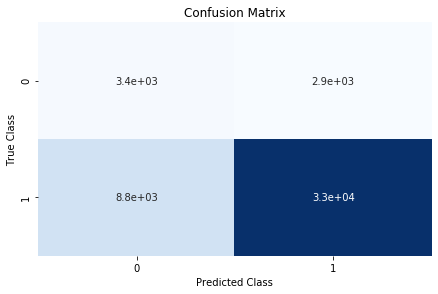

0.7558550688464578


In [164]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
ytrue=result['content_type']
ypre=result['emotion_type']
matrix=confusion_matrix(ytrue,ypre)
dataframe=pd.DataFrame(matrix)
sns.heatmap(dataframe,annot=True,cbar=None,cmap='Blues')
plt.title('Confusion Matrix'),plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()
print(accuracy_score(ytrue,ypre))

从结果可以看出利用情感分析得出的情感倾向与评星得出的情感倾向有73.689%的相似性

提取正面和负面的情感

In [165]:
ind_pos=list(emotional_value[emotional_value['emotion_type']=='pos']['index_content'])
ind_neg=list(emotional_value[emotional_value['emotion_type']=='neg']['index_content'])

In [166]:
word.index=range(word.shape[0])

In [167]:
index=[]
for i in ind_pos:
    li=list(word[word['index_content']==i].index)
    for j in li:
        index.append(j)
posdata=word.iloc[index,:]
index_=[]
for i in ind_neg:
    wa=list(word[word['index_content']==i].index)
    for j in wa:
        index_.append(j)
negdata=word.iloc[index_,:]

将正面情感信息和负面情感信息储存

In [168]:
posdata.to_csv("./posdata.csv")
negdata.to_csv("./negdata.csv")

# 三.建模预测

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import  BernoulliNB
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score,recall_score
import imblearn
from imblearn.over_sampling import SMOTE

In [170]:
X_=movie['Comment']
movie_=movie.copy()
for i in [1,2,3,4,5]:
    if i>=3:
        movie_['Star']=movie_['Star'].replace(i,'1')
    else:
        movie_['Star']=movie_['Star'].replace(i,'0')

In [171]:
movie_.head()

,Movie_Name_CN,Comment,Star
0,大圣归来,情怀,1
1,夏洛特烦恼,看的时候笑得不要不要的但是我不喜欢这片子传递的价值观,1
2,左耳,水军是没有看电影电影里面哪里有怀孕堕胎虽然小说里面是有的我不说他拍的特别好至少有哭点有泪点我...,1
3,美人鱼,虽然剧情没新意但是段子都好好笑特别是警局那段全场爆笑环保也起到了效果看完再也不想吃整条鱼最大...,1
4,后会无期,我们就像公路,1


划分训练集和测试集

In [172]:
X_=movie_['Comment']
y_=movie_['Star']
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X_,y_,test_size=0.3,random_state=420)

利用TFIDF计算词频,将训练集和测试集转化成稀疏矩阵的形式

In [173]:
model_tfidf = TFIDF(min_df=5, max_features=5000, ngram_range=(1,3), use_idf=1, smooth_idf=1)
model_tfidf.fit(Xtrain)
train_vec=model_tfidf.transform(Xtrain)
test_vec=model_tfidf.transform(Xtest)

In [174]:
movie_['Star'].value_counts()

1    16546
0     3454
Name: Star, dtype: int64

此数据集有样本不均衡的问题，因此我们采取上采样的方式对训练集的样本不均衡进行修正

In [175]:
sm=SMOTE(random_state=420)
train_vec_,Ytrain_=sm.fit_resample(train_vec,Ytrain)

建模预测

In [176]:
clf=BernoulliNB().fit(train_vec_,Ytrain_)
ypred=clf.predict(test_vec)
prob=clf.predict_proba(test_vec)

查看布里尔分数

In [177]:
brier_score_loss(Ytest,prob[:,1],pos_label=1)

0.2550555216375442

查看精确度

In [178]:
accuracy_score(Ytest,ypred)

0.8223333333333334

由布里尔分数和精确度两个指标可以看出模型的预测效果良好

# 四.电影推荐

查看每个电影所拥有的评论数

In [179]:
movie_['Movie_Name_CN'].value_counts()

疯狂动物城     1308
大圣归来      1272
后会无期      1099
寻龙诀       1061
你的名字      1034
釜山行       1017
夏洛特烦恼      998
爱乐之城       930
小时代1       849
西游伏妖篇      820
大鱼海棠       816
泰囧         794
长城         790
西游降魔篇      789
复仇者联盟      777
美人鱼        680
七月与安生      621
美国队长3      613
变形金刚4      535
复仇者联盟2     499
小时代3       409
左耳         399
十二生肖       393
九层妖塔       392
湄公河行动      341
栀子花开       282
何以笙箫默      253
钢铁侠1       229
Name: Movie_Name_CN, dtype: int64

In [180]:
result1.head()

,index_content,amend_weight,emotion_type,word,nature,content_type,index_word
0,11,-1.0,0,太,d,1,0
1,11,-1.0,0,垃圾,n,1,1
2,11,-1.0,0,低,a,1,2
3,17,-1.0,0,刺金,n,0,0
4,17,-1.0,0,时代,n,0,1


In [181]:
result1=result.replace('neg',0)
result1=result1.replace('pos',1)

将所有的正面评价数目和评价的数量累加起来

In [182]:
result2=result1.groupby('index_content').agg(正面评价数=('content_type','sum'),
                                    评论数量=('index_content','count')).reset_index()

In [183]:
result2

,index_content,正面评价数,评论数量
0,2,5,5
1,25,10,10
2,33,12,12
3,36,28,28
4,52,21,21
...,...,...,...
2950,19976,15,15
2951,19977,8,8
2952,19986,4,4
2953,19993,41,41


In [184]:
content=result2['index_content'].values.tolist()
movie_name=[]
for i in content:
    name=movie_['Movie_Name_CN'][i-1]#因为根据原来数据第一条评论对应的索引为0，因此i需要减1
    movie_name.append(name)
result2['name_movie']=movie_name

In [185]:
#这里的正面评价数量，不是正面评论数量，而是有正面情感词的数量
result_content=result2.groupby('name_movie').agg(电影的正面评价数=('正面评价数','sum'),
                                    电影的评论数量=('评论数量','sum')).reset_index()
result_content['正面评价比率']=round(result_content['电影的正面评价数']/result_content['电影的评论数量'],4)
result_content.sort_values('正面评价比率',inplace=True,ascending=False)

In [186]:
result_content

,name_movie,电影的正面评价数,电影的评论数量,正面评价比率
22,美国队长3,1145,1145,1.0000
26,钢铁侠1,209,209,1.0000
20,疯狂动物城,2844,2877,0.9885
3,你的名字,2311,2362,0.9784
7,复仇者联盟,847,879,0.9636
25,釜山行,2143,2263,0.9470
6,后会无期,2744,2932,0.9359
12,寻龙诀,2545,2720,0.9357
10,大圣归来,4009,4287,0.9352
19,爱乐之城,3031,3246,0.9338


从对电影正面评价率的数据来看，美国队长3和钢铁侠1的正面评价率达到了百分之百，说明这两部电影深受观众的喜爱，可以尝试在原来电影的基础上拍续集；而像何以笙箫默和小时代3的正面评价率很低，说明这两部电影不适合再拍续集或者有很多需要改进的地方。

# 五.正负面情感主要影响因素

这一节主要探索观众的正负面情感主要受到电影中的哪些因素的影响，因此主要探索的是正负面情感词中含名词词性的词。

取出所有含名词词性的正面情感词和负面情感词

In [187]:
posdata.index=range(posdata.shape[0])
p_nature=[]
pos_nature=posdata['nature'].values.tolist()
for i in posdata.index:
    if pos_nature[i].find('n')==0:
        p_nature.append(i)
posdata_n=posdata.iloc[p_nature,:]

In [188]:
posdata_n.head()

,index_content,word,nature,content_type,index_word
2,2,片子,n,pos,2
4,2,价值观,n,pos,4
9,25,渤了,n,pos,4
11,25,结尾,n,pos,6
14,25,棺材,n,pos,9


In [189]:
negdata.index=range(negdata.shape[0])
n_nature=[]
neg_nature=negdata['nature'].values.tolist()
for i in negdata.index:
    if neg_nature[i].find('n')==0:
        n_nature.append(i)
negdata_n=negdata.iloc[n_nature,:]

In [190]:
negdata_n.head()

,index_content,word,nature,content_type,index_word
2,52,槽,ng,pos,2
5,52,买票,n,pos,5
7,52,心,n,pos,7
10,52,广告,n,pos,10
11,52,笑点,n,pos,11


画词云

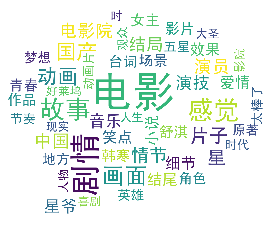

In [191]:
backgroud_Image=plt.imread(path+'/pl.jpg')
font_path=path+'/SimHei.ttf'
freq_pos=posdata_n.groupby('word')['word'].count()
freq_pos=freq_pos.sort_values(ascending=True)
backgroud_Image=plt.imread(path+'/pl.jpg')
wordcloud=WordCloud(font_path=font_path,
                   max_words=50,
                   background_color='white',
                   mask=backgroud_Image)
pos_wordcloud=wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

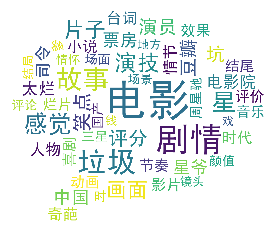

In [192]:
freq_neg=negdata_n.groupby('word')['word'].count()
freq_neg=freq_neg.sort_values(ascending=True)
backgroud_Image=plt.imread(path+'/pl.jpg')
wordcloud=WordCloud(font_path=font_path,
                   max_words=50,
                   background_color='white',
                   mask=backgroud_Image)
neg_wordcloud=wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

像电影、片子这类词在此案例中对分析没什么太大作用因此考虑删除

In [195]:
posdata_n=posdata_n[posdata_n['word']!='电影']
posdata_n=posdata_n[posdata_n['word']!='片子']
negdata_n=negdata_n[negdata_n['word']!='电影']
negdata_n=negdata_n[negdata_n['word']!='片子']

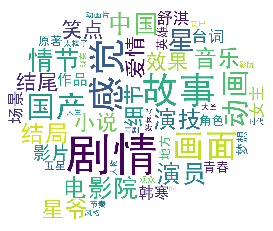

In [196]:
freq_pos=posdata_n.groupby('word')['word'].count()
freq_pos=freq_pos.sort_values(ascending=True)
backgroud_Image=plt.imread(path+'/pl.jpg')
wordcloud=WordCloud(font_path=font_path,
                   max_words=50,
                   background_color='white',
                   mask=backgroud_Image)
pos_wordcloud=wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

此时从正面情感词的词云图可以看出，影响正面情感评论最主要的有电影的剧情、故事情节，演员演技，国产等

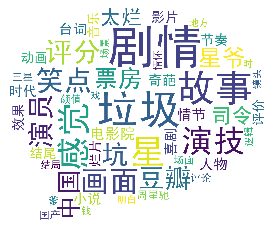

In [197]:
freq_neg=negdata_n.groupby('word')['word'].count()
freq_neg=freq_neg.sort_values(ascending=True)
backgroud_Image=plt.imread(path+'/pl.jpg')
wordcloud=WordCloud(font_path=font_path,
                   max_words=50,
                   background_color='white',
                   mask=backgroud_Image)
neg_wordcloud=wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

由负面情感词云图可以看出影响负面情感词最主要的因素是剧情，故事情节,演员的演技等。

# 六.通过LDA模型进行主题寻优

In [283]:
import re
import itertools

from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

下面对正面情感词进行主题寻优（经过调节n_topics发现主题为3的时候最后可视化后结果各圆没有重叠）

In [284]:
n_features = 1000
vectorizer = CountVectorizer(max_features=n_features,#只取前1000个作为关键词集
                                max_df = 0.5, #最大不能超过50%
                                min_df = 10)#最小要有十个词出现
pf = vectorizer.fit_transform(posdata_n['word'].values.tolist())


In [285]:
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(pf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=3,
                          random_state=0)

In [286]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [287]:
n_top_words = 15
pf_feature_names = vectorizer.get_feature_names()
topic_word = print_top_words(lda, pf_feature_names, n_top_words)

Topic #0:
感觉 故事 国产 效果 爱情 影片 台词 角色 青春 地方 动画片 好莱坞 影院 丧尸 镜头
Topic #1:
剧情 画面 演技 结局 小说 笑点 女主 舒淇 作品 英雄 原著 太棒了 观众 人物 人生
Topic #2:
动画 情节 中国 电影院 演员 音乐 星爷 结尾 细节 场景 韩寒 梦想 五星 节奏 时代


In [289]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, pf,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.247172 -0.263386       1        1  34.552830
2     -0.104750  0.345529       2        1  33.417352
1      0.351921 -0.082142       3        1  32.029818, topic_info=     Term        Freq       Total Category  logprob  loglift
36     剧情  311.000000  311.000000  Default  30.0000  30.0000
125    感觉  191.000000  191.000000  Default  29.0000  29.0000
133    故事  184.000000  184.000000  Default  28.0000  28.0000
186    画面  153.000000  153.000000  Default  27.0000  27.0000
41     动画  123.000000  123.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
225    评论   22.413591   23.050195   Topic3  -4.6236   1.1105
43   动画电影   21.409817   22.046422   Topic3  -4.6694   1.1092
31     内容   21.409817   22.046422   Topic3  -4.6694   1.1092
201    经典   20.406042   21.042649   Topic3  -4.7175   1.1078
27     兔子   20.406042   21.042649   Topic3  -4.7175   1.1078

[120 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.984193   三星
3         3  0.964205   世界
5         1  0.971276   东西
6         1  0.990432   丧尸
7         2  0.994174   中国
...     ...       ...  ...
243       3  0.959269   韩国
244       2  0.984163   韩寒
245       2  0.986613   音乐
247       1  0.989030   题材
248       3  0.973366   风格

[90 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

根据上面的分析可以得出，中国观众更加喜爱具有丰富故事情节的电影，还有中国的观众相对于电影拥有豪华明星阵容的片子更喜欢拥有优质剧情的电影

根据LDA模型分析可以得出结论：在制作电影的过程中，制片方应该更加注重电影的剧情以及电影所呈现的画面，同时寻找演技精湛的演员，这样可以提高观众对这部电影的好评；
同时可以看出很多人还是更加支持国产的电影，特别是动画这块，因此制片方也可以出一些拥有耐人寻味故事情节，并且可以给人带来视觉盛宴的动画电影；不仅如此，电影带给人身临其境
的感觉也将是这部电影成功不可或缺的因素。